In [25]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import itertools
from itertools import cycle
import joblib
import math
from PIL import Image, ImageDraw
import face_recognition
from sklearn.neural_network import MLPClassifier
import random
import time
from sklearn.metrics import precision_recall_curve, f1_score, PrecisionRecallDisplay
from sklearn.utils import resample
import tkinter as tk
from tkinter import messagebox
import threading

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
data = pd.read_csv(r'D:\School Work\College\DIP\Hair_Style_Recommendation-master\Hair_Style_Recommendation-master\all_features.csv', index_col=None)
data = data.drop('Unnamed: 0', axis=1)
data_clean = data.dropna(axis=0, how='any')
X = data_clean.drop(['filenum', 'filename', 'classified_shape'], axis=1)
Y = data_clean['classified_shape']

In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.25, random_state=1200)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(60,10,60,30), solver='sgd',shuffle  = True, 
                    learning_rate_init=0.01, max_iter = 200,warm_start  = False)

from sklearn.model_selection import RandomizedSearchCV 
param_grid = { 
    'learning_rate_init':[0.01]   # always the best
    ,'hidden_layer_sizes': [x for x in itertools.product((10,20,30,40,50,60,100),repeat=4)]
    ,'max_iter': [100] # always the best
    ,'random_state': [525]
}

random_search = RandomizedSearchCV(estimator=mlp, param_distributions=param_grid, cv= 10, n_iter = 100)
random_search.fit(X_train, Y_train)
print(random_search.best_estimator_)

In [29]:
mlp_best = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60, 100, 30, 100), learning_rate='constant',
       learning_rate_init=0.01, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=525,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
mlp_best.fit(X_train, Y_train)
Y_pred = mlp_best.predict(X_test)
print("Classification Report on Test Set:")
print(classification_report(Y_test,Y_pred))

Classification Report on Test Set:
              precision    recall  f1-score   support

       heart       0.69      0.65      0.67        75
        long       0.75      0.68      0.71        68
        oval       0.60      0.72      0.65        99
       round       0.71      0.74      0.72        62
      square       0.74      0.62      0.68        72

    accuracy                           0.68       376
   macro avg       0.70      0.68      0.69       376
weighted avg       0.69      0.68      0.68       376



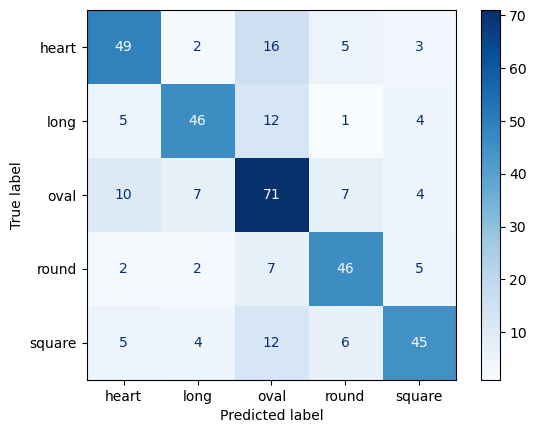

In [30]:
Y_pred = mlp_best.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred, labels=mlp_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_best.classes_)
disp.plot(cmap='Blues')
plt.show()

In [62]:
from sklearn.preprocessing import label_binarize

# Binarize the output for multiclass one-vs-rest handling
y_test_binarized = label_binarize(Y_test, classes=np.unique(Y))
n_classes = y_test_binarized.shape[1]

# Wrap the MLP model with OneVsRestClassifier
mlp_ovr = OneVsRestClassifier(mlp_best)
mlp_ovr.fit(X_train, Y_train)

# Define number of bootstrap samples
n_bootstraps = 10000
random_seed = 42

# Store precision, recall, and F1 scores for each class
precision_scores = {i: [] for i in range(n_classes)}
recall_scores = {i: [] for i in range(n_classes)}
f1_scores = {i: [] for i in range(n_classes)}

for _ in range(n_bootstraps):
    # Generate a bootstrap sample
    X_test_bootstrap, y_test_bootstrap = resample(X_test, y_test_binarized, random_state=random_seed)
    
    # Get the model's probabilities for each class and calculate precision, recall
    y_probs = mlp_ovr.predict_proba(X_test_bootstrap)
    y_pred = mlp_ovr.predict(X_test_bootstrap)  # Predict class labels

    # Convert predictions to a binary indicator matrix for calculating per-class F1
    y_pred_binarized = label_binarize(y_pred, classes=np.unique(Y))

    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bootstrap[:, i], y_probs[:, i])
        f1 = f1_score(y_test_bootstrap[:, i], y_pred_binarized[:, i])
        
        precision_scores[i].append(precision)
        recall_scores[i].append(recall)
        f1_scores[i].append(f1)

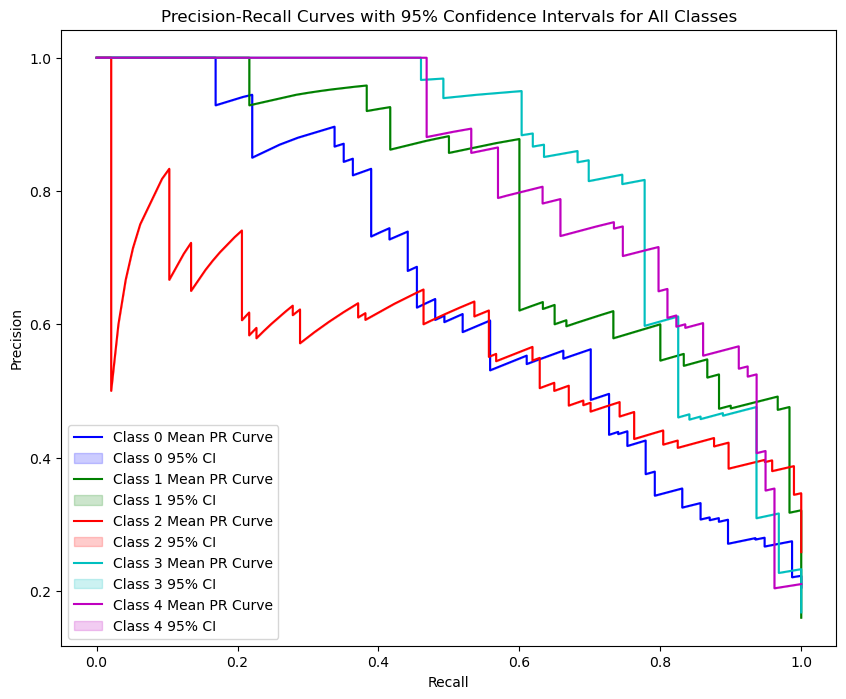

In [63]:
# Plot all classes' precision-recall curves on the same graph
plt.figure(figsize=(10, 8))
colors = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])  # Cycle through colors
n_classes = y_test_binarized.shape[1]
class_names = [f"Class {i}" for i in range(n_classes)]

for i, color in zip(range(n_classes), colors):
    mean_precision = np.mean(precision_scores[i], axis=0)
    mean_recall = np.mean(recall_scores[i], axis=0)
    
    plt.plot(mean_recall, mean_precision, color=color, label=f'{class_names[i]} Mean PR Curve')
    plt.fill_between(mean_recall,
                     np.percentile(precision_scores[i], 2.5, axis=0),
                     np.percentile(precision_scores[i], 97.5, axis=0),
                     color=color, alpha=0.2, label=f"{class_names[i]} 95% CI")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves with 95% Confidence Intervals for All Classes')
plt.legend()
plt.show()

In [47]:
print(mlp_best.score(X_train, Y_train))
mlp_score = mlp_best.score(X_test,Y_test)
print(mlp_score)

1.0
0.6835106382978723


In [48]:
def make_face_df(image_select):
    pts = []
    face = 0
    image = face_recognition.load_image_file(image_select)
    face_landmarks_list = face_recognition.face_landmarks(image)

    # Exit if no landmark detected
    if not face_landmarks_list:
        print("No face landmarks detected!")
        return None

    for face_landmarks in face_landmarks_list:
        face += 1
        if face > 1:    # this will only measure one face per image
            break
        else:
            # Facial feature list
            facial_features = ['chin','left_eyebrow','right_eyebrow','nose_bridge','nose_tip','left_eye','right_eye','top_lip','bottom_lip']

            # Append facial points
            for facial_feature in facial_features:
                for point in face_landmarks[facial_feature]:
                    pts.extend(point)
                    
        i = 0
        for j in range(0,17):
            if i != 16:
                if i != 17:
                    px = pts[i]
                    py = pts[i+1]
                    chin_x = pts[16]   # always the chin x
                    chin_y = pts[17]   # always the chin y
                    x_diff = float(px - chin_x)
                    if(py == chin_y): 
                        y_diff = 0.1
                    if(py < chin_y): 
                        y_diff = float(np.absolute(py-chin_y))
                    if(py > chin_y):
                        y_diff = 0.1
                        print("Error: facial feature is located below the chin.")
                    angle = np.absolute(math.degrees(math.atan(x_diff/y_diff)))
                    pts.append(angle)
            i += 2
        
        pil_image = Image.fromarray(image)
        d = ImageDraw.Draw(pil_image)

        for facial_feature in facial_features:
                #d.line(face_landmarks[facial_feature], width=5)
                d.point(face_landmarks[facial_feature], fill = (255,255,255))
            
        pil_image.save(str(image_select) + '_NEW_rotated_pts.jpg', 'JPEG', quality = 100)

    # Check if enough points were detected
    if len(pts) < 18:
        print("Not enough facial landmarks detected, skipping frame.")
        return None

    # Face width and height measurements
    a, b, c, d = pts[0], pts[1], pts[32], pts[33]
    e, f, g, h = pts[16], pts[17], pts[56], pts[57]
    i, j, k, l = pts[12], pts[13], pts[20], pts[21]
    m, n, o, p = pts[8], pts[9], pts[24], pts[25]

    face_width = np.sqrt((a - c) ** 2 + (b - d) ** 2)
    pts.append(face_width)
    face_height = np.sqrt((e - g) ** 2 + (f - h) ** 2) * 2
    pts.append(face_height)
    pts.append(face_height / face_width)

    jaw_width = np.sqrt((i - k) ** 2 + (j - l) ** 2)
    pts.append(jaw_width)
    pts.append(jaw_width / face_width)

    mid_jaw_width = np.sqrt((m - o) ** 2 + (n - p) ** 2)
    pts.append(mid_jaw_width)
    pts.append(mid_jaw_width / jaw_width)
    
    # Ensure the number of features matches the expected count (167), pad if necessary
    if len(pts) < 167:
        pts.extend([0] * (167 - len(pts)))

    return pts

In [49]:
def overlay_hairstyle(frame, x, y, w, h, hairstyle_img_path, scale_factor=1.2):
    # Load the hairstyle image with alpha channel
    hairstyle_img = cv2.imread(hairstyle_img_path, cv2.IMREAD_UNCHANGED)
    if hairstyle_img is None:
        print(f"Error loading image: {hairstyle_img_path}")
        return

    # Separate color and alpha channels if available
    if hairstyle_img.shape[2] == 4:
        hairstyle_bgr = hairstyle_img[:, :, :3]
        alpha_mask = hairstyle_img[:, :, 3]
    else:
        hairstyle_bgr = hairstyle_img
        alpha_mask = np.ones(hairstyle_bgr.shape[:2], dtype=np.uint8) * 255

    # Calculate dynamic scale factor based on face size (using width and height)
    dynamic_scale_factor = scale_factor * ((w + h) / 400)  # Normalize based on typical face size
    new_width = int(w * dynamic_scale_factor)
    new_height = int(hairstyle_bgr.shape[0] * (new_width / hairstyle_bgr.shape[1]))  # Maintain aspect ratio

    # Resize the hairstyle and alpha mask
    hairstyle_bgr = cv2.resize(hairstyle_bgr, (new_width, new_height), interpolation=cv2.INTER_AREA)
    alpha_mask = cv2.resize(alpha_mask, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Adjust position to align hairstyle with forehead
    x_offset = x + (w - new_width) // 2  # Center horizontally over face
    y_offset = y - new_height + int(h * 0.1)  # Offset above forehead

    # Clip offsets to frame boundaries
    x_offset = max(0, min(x_offset, frame.shape[1] - new_width))
    y_offset = max(0, min(y_offset, frame.shape[0] - new_height))

    # Clip hairstyle if it goes outside the frame
    overlay_width = min(new_width, frame.shape[1] - x_offset)
    overlay_height = min(new_height, frame.shape[0] - y_offset)

    # Update the hairstyle and mask sizes if clipped
    hairstyle_bgr = hairstyle_bgr[:overlay_height, :overlay_width]
    alpha_mask = alpha_mask[:overlay_height, :overlay_width]

    # Region of interest from the frame where the hairstyle will be placed
    roi = frame[y_offset:y_offset + overlay_height, x_offset:x_offset + overlay_width]

    # Blend the hairstyle with the ROI using the alpha mask
    alpha_mask = alpha_mask / 255.0
    alpha_inv = 1.0 - alpha_mask

    # Blend each channel separately
    for c in range(3):
        roi[:, :, c] = (alpha_mask * hairstyle_bgr[:, :, c] + alpha_inv * roi[:, :, c])

    # Place blended region back into the frame
    frame[y_offset:y_offset + overlay_height, x_offset:x_offset + overlay_width] = roi


In [50]:
# Dictionary to store haircut recommendations based on face shape
haircut_recommendations_male = {
    'oval': ['Male_Oval_DownPerm', 'Male_Oval_SidePartedShort', 'Male_Oval_Mohawk', 'Male_Oval_Short_curl', 'Male_Oval_Edgar'],
    'square': ['Male_Square_SlickedBackSidePart', 'Male_Square_CombOver'],
    'heart': ['Male_Heart_ElaboratePushback', 'Male_Heart_Pompadour'],
    'long': ['Male_Long_IvyLeague'],
    'round': ['Male_Round_BlackMullet', 'Male_Round_FauxHawk', 'Male_Round_Quiff', 'Male_Round_Bowl']
}

# Dictionary to store haircut recommendations based on face shape
haircut_recommendations_female = {
    'oval': ['Female_Oval_BlackBob', 'Female_Oval_FringeUp', 'Female_Oval_LongBangs'],
    'square': ['Female_Square_BlackAfro'],
    'heart': ['Female_Heart_BlondeCurlyHair', 'Female_Heart_LongFringes'],
    'long': ['Female_Long_BlondePixieCut'],
    'round': ['Female_Round_BobLayered']
}

In [51]:
def capture_and_predict(mlp_best, scaler):
    global selected_gender
    if selected_gender is None:
        print("Gender not selected. Exiting.")
        return

    # Use the correct haircut recommendations based on selected gender
    if selected_gender == 'male':
        haircut_recommendations = haircut_recommendations_male
    elif selected_gender == 'female':
        haircut_recommendations = haircut_recommendations_female
    else:
        print("Unknown gender selection.")
        return

    # Load OpenCV's pre-trained Haar Cascade for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    cap = cv2.VideoCapture(0)  # Open the default camera

    start_time = time.time()
    duration = 30

    last_update_time = 0  # Time tracker for 5-second hairstyle update
    last_predicted_shape = None  # Store the previous face shape to detect changes

    # Active windows for hairstyles
    active_hairstyle_windows = []

    # Calculate the position of the main video frame at the bottom right
    window_height = 600
    window_width = 643
    main_window_x = 1280
    main_window_y = 600
    screen_width, screen_height = 1920, 1080  # Screen dimensions
    cached_hairstyle = None

    while True:
        if stop_event.is_set():
            break

        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        # Convert the frame to grayscale for face detection
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(
            gray_frame, 
            scaleFactor=1.05,
            minNeighbors=4,
            minSize=(100, 100)
        )

        if len(faces) > 0:
            (x, y, w, h) = faces[0]  # Use the first detected face
        else:
            print('No face detected')
            continue  # Skip loop if no face is detected

        # Crop and prepare the face for feature extraction
        cropped_face = frame[y:y+ int(h*1.2), x:x+ int(w*1.2)]
        cropped_face_resized = cv2.resize(cropped_face, (300, 300))

        # Save the cropped face temporarily for feature extraction
        temp_img_path = "temp_frame.jpg"
        cv2.imwrite(temp_img_path, cropped_face_resized)

        # Extract facial features
        face_features = make_face_df(temp_img_path)

        if face_features:
            face_features_scaled = scaler.transform([face_features])
            # Predict face shape
            face_shape_prediction = mlp_best.predict(face_features_scaled)
            predicted_shape = face_shape_prediction[0]

            # Check if it's time to update hairstyles (every 5 seconds)
            if time.time() - last_update_time >= 5:
                last_update_time = time.time()  # Reset the timer

                # If the predicted shape has changed, close existing windows
                if predicted_shape != last_predicted_shape:
                    # Close any remaining hairstyle windows safely
                    for window_name in active_hairstyle_windows:
                        try:
                            # Check if the window still exists before attempting to destroy it
                            if cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE) >= 1:
                                cv2.destroyWindow(window_name)
                        except cv2.error as e:
                            print(f"Warning: Could not close window '{window_name}'. Error: {e}")
                    active_hairstyle_windows.clear()

                    # Update the last predicted shape
                    last_predicted_shape = predicted_shape

                    # Display new set of recommended hairstyles
                    recommended_haircuts = haircut_recommendations.get(predicted_shape, [])
                    
            # Calculate confidence
            if hasattr(mlp_best, "predict_proba"):
                confidence = np.max(mlp_best.predict_proba(face_features_scaled)) * 100
                print(f"Predicted Face Shape: {predicted_shape}, Confidence: {confidence:.2f}%")

                for idx, haircut_name in enumerate(recommended_haircuts):
                    # Set hairstyle image path
                    hairstyle_img_path = os.path.join(
                        "D:/School Work/College/DIP/Hair_Style_Recommendation-master/Hair_Style_Recommendation-master/data/Hairstyles",
                        f"{haircut_name}.png"
                    )
                
                    # Ensure that the haircut_name is a valid string
                    if not isinstance(haircut_name, str) or not haircut_name:
                        print(f"Invalid haircut_name at index {idx}: '{haircut_name}'")
                        continue
                
                    # Overlay hairstyle onto the frame
                    frame_with_overlay = frame.copy()
                    overlay_hairstyle(frame_with_overlay,x, y, w, h, hairstyle_img_path)

                    max_windows_per_row = screen_width // window_width
                
                    # Calculate window position avoiding the bottom right
                    row = idx // max_windows_per_row
                    col = idx % max_windows_per_row
                    window_x = col * window_width
                    window_y = row * window_height
                
                    # Adjust if window is in the main window area
                    if (window_x >= main_window_x and window_y >= main_window_y):
                        window_y -= window_height  # Shift up if it would overlap main window
                
                    # Construct a valid window name as a string
                    window_name = f"Hairstyle: {haircut_name} ({idx + 1})"
                    print(f"Creating window with name: {window_name} (type: {type(window_name)})")
                    
                    try:
                        # Display and move window, ensuring window_name is passed as a string
                        cv2.imshow(str(window_name), frame_with_overlay)
                        cv2.moveWindow(str(window_name), window_x, window_y)
                        active_hairstyle_windows.append(window_name)
                        print(f"Displayed window '{window_name}' at position ({window_x}, {window_y})")
                    
                    except Exception as e:
                        print(f"Error with window '{window_name}': {e}")
                    
            # Overlay face shape info in real-time on the original frame
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            cv2.putText(frame, f"Face Shape: {predicted_shape}, Confidence: {np.max(mlp_best.predict_proba(face_features_scaled)) * 100:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Show the main video frame at the bottom right
        cv2.imshow('Live Face Shape Prediction', frame)
        cv2.moveWindow('Live Face Shape Prediction', main_window_x, main_window_y)

        # Break after duration or if 'q' is pressed
        if time.time() - start_time > duration or cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [52]:
# Global variable to control when to stop the video capture
stop_event = threading.Event()
selected_gender = None

# Thread wrapper for capture_and_predict
def capture_and_predict_thread(mlp_best, scaler):
    # Close any lingering OpenCV windows before starting a new session
    stop_capture()
    cv2.destroyAllWindows()  # Close any lingering windows

    # Reset stop event
    stop_event.clear()

    # Start capture_and_predict in a new thread
    threading.Thread(target=capture_and_predict, args=(mlp_best, scaler)).start()

# Function to ask for gender selection in the GUI
def set_gender(gender):
    global selected_gender
    selected_gender = gender
    print(f"Selected Gender: {gender}")
    
# Stop function to gracefully stop the capture
def stop_capture():
    # Set the stop event to stop the OpenCV video loop
    stop_event.set()

    # Close any OpenCV windows
    cv2.destroyAllWindows()

# GUI function with gender selection and video capture start
def create_gui(mlp_best, scaler):
    root = tk.Tk()
    root.title("Face Shape Prediction & Hairstyle Overlay")

    # Gender selection buttons
    gender_label = tk.Label(root, text="Select Gender:")
    gender_label.pack(pady=10)

    male_button = tk.Button(root, text="Male", command=lambda: set_gender('male'))
    male_button.pack(pady=5)

    female_button = tk.Button(root, text="Female", command=lambda: set_gender('female'))
    female_button.pack(pady=5)

    # Start button to begin video capture and prediction
    start_button = tk.Button(root, text="Start Capture and Predict", command=lambda: capture_and_predict_thread(mlp_best, scaler))
    start_button.pack(pady=20)

    # Quit button to stop video capture and exit the program
    quit_button = tk.Button(root, text="Quit", command=lambda: quit_program(root))
    quit_button.pack(pady=10)

    # Start the GUI event loop
    root.mainloop()

# Function to quit the program safely
def quit_program(root):
    # Stop the capture process
    stop_capture()

    # After stopping capture, close the Tkinter window
    root.quit()
    root.destroy()

In [53]:
create_gui(mlp_best, scaler)

Selected Gender: male
Predicted Face Shape: oval, Confidence: 100.00%
Creating window with name: Hairstyle: Male_Oval_DownPerm (1) (type: <class 'str'>)
Displayed window 'Hairstyle: Male_Oval_DownPerm (1)' at position (0, 0)
Creating window with name: Hairstyle: Male_Oval_SidePartedShort (2) (type: <class 'str'>)
Displayed window 'Hairstyle: Male_Oval_SidePartedShort (2)' at position (643, 0)
Creating window with name: Hairstyle: Male_Oval_Mohawk (3) (type: <class 'str'>)
Displayed window 'Hairstyle: Male_Oval_Mohawk (3)' at position (0, 600)
Creating window with name: Hairstyle: Male_Oval_Short_curl (4) (type: <class 'str'>)
Displayed window 'Hairstyle: Male_Oval_Short_curl (4)' at position (643, 600)
Creating window with name: Hairstyle: Male_Oval_Edgar (5) (type: <class 'str'>)
Displayed window 'Hairstyle: Male_Oval_Edgar (5)' at position (0, 1200)
Predicted Face Shape: oval, Confidence: 100.00%
Creating window with name: Hairstyle: Male_Oval_DownPerm (1) (type: <class 'str'>)
Displ